In [1]:
# Importing required libraries for Logistic Regression and data processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

In [2]:
# Load the dataset
file_path = "C:\\Users\\Nirusan03\\PycharmProjects\\MIS710_Course_Work\\LA4PSchools.csv"
data = pd.read_csv(file_path)

# Display first few rows of the dataset
data.head()

,StudentID,Gender,Year_02,Kinder_Age,Disability,NCCD-Funded,01.SES,02.SES,NumSibling,SiblingOrder,...,HRSIW-01-SOY,Counting-01,Counting-02,Place Value-01,Place Value-02,Addition and Subtraction-01,Addition and Subtraction-02,Multiplication and Division-01,Multiplication and Division-02,Year3_Writing_At_Risk
0,SN35433053,Male,2020,5.5,Disability_Non-disable,0,104,104,3,3,...,49,4,5,2,2,2,4,2,2,False
1,SN71277215,Female,2018,5.8,Disability_Non-disable,0,112,112,2,2,...,37,2,1,1,1,2,3,0,2,False
2,SN40883127,Male,2021,5.9,Disability_Non-disable,0,120,109,2,2,...,30,2,1,1,2,2,1,2,1,False
3,SN93063777,Male,2021,5.7,Disability_Non-disable,0,95,93,2,1,...,30,2,3,1,2,1,5,2,2,False
4,SN84195329,Male,2021,5.8,Disability_Non-disable,0,98,98,1,1,...,32,2,4,2,2,2,4,1,1,True


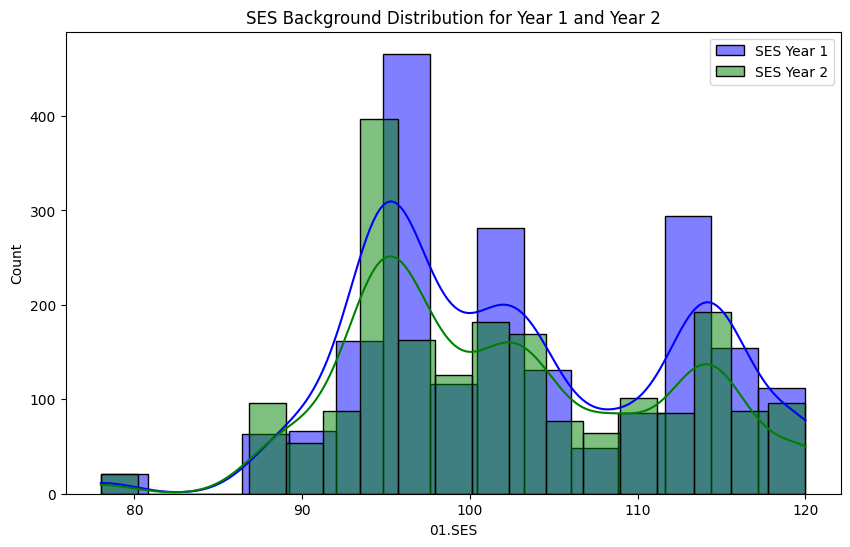

In [3]:
# Exploratory Data Analysis (Answer Q1)
# SES Distribution for Year 1 and Year 2
plt.figure(figsize=(10, 6))
sns.histplot(data['01.SES'], kde=True, color='blue', label='SES Year 1')
sns.histplot(data['02.SES'], kde=True, color='green', label='SES Year 2')
plt.title("SES Background Distribution for Year 1 and Year 2")
plt.legend()
plt.show()

In [23]:
# Preprocessing function
def preprocess_data(data):
    # Convert 'Year3_Writing_At_Risk' to 0/1 (True/False -> 1/0)
    data['Year3_Writing_At_Risk'] = data['Year3_Writing_At_Risk'].astype(int)

    # One-hot encoding for categorical variables ('Gender', 'Disability')
    categorical_features = ['Gender', 'Disability']
    data_encoded = pd.get_dummies(data, columns=categorical_features, drop_first=True)

    # Split features (X) and target (y)
    X = data_encoded.drop(columns=['StudentID', 'Year3_Writing_At_Risk'])
    y = data_encoded['Year3_Writing_At_Risk']

    # Apply SMOTE for class imbalance
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Scale the features
    scaler = StandardScaler()
    X_resampled_scaled = scaler.fit_transform(X_resampled)

    return X_resampled_scaled, y_resampled

# Preprocess the data
X_scaled, y = preprocess_data(data)

# Display the shape of processed data
X_scaled.shape, y.shape

((2668, 35), (2668,))

In [24]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Check the shapes of training and testing sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2134, 35), (534, 35), (2134,), (534,))

In [25]:
# Define parameter grid for Logistic Regression
param_grid_lr = [
    {'C': [0.01, 0.1, 1, 10, 100], 
     'solver': ['liblinear', 'saga'], 
     'penalty': ['l1', 'l2'], 
     'class_weight': ['balanced']},  # L1 and L2 regularization for liblinear and saga
     
    {'C': [0.01, 0.1, 1, 10, 100], 
     'solver': ['lbfgs', 'newton-cg', 'sag'], 
     'penalty': ['l2'], 
     'class_weight': ['balanced']}  # L2 regularization for lbfgs, newton-cg, sag
]

# Instantiate Logistic Regression model with a large max_iter for convergence
lr = LogisticRegression(random_state=42, max_iter=10000)

# Grid search with 5-fold cross-validation
grid_lr = GridSearchCV(lr, param_grid_lr, cv=5, n_jobs=-1, verbose=1)
grid_lr.fit(X_train, y_train)

Fitting 5 folds for each of 35 candidates, totalling 175 fits


GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=10000, random_state=42),
             n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100],
                          'class_weight': ['balanced'], 'penalty': ['l1', 'l2'],
                          'solver': ['liblinear', 'saga']},
                         {'C': [0.01, 0.1, 1, 10, 100],
                          'class_weight': ['balanced'], 'penalty': ['l2'],
                          'solver': ['lbfgs', 'newton-cg', 'sag']}],
             verbose=1)

In [26]:
# Get predictions from the best model
lr_predictions = grid_lr.best_estimator_.predict(X_test)

# Evaluate the accuracy and classification report
lr_accuracy = accuracy_score(y_test, lr_predictions)
lr_report = classification_report(y_test, lr_predictions)

# Print results
print("Best Hyperparameters for Logistic Regression:", grid_lr.best_params_)
print(f"Accuracy: {lr_accuracy * 100:.2f}%")
print("Classification Report:\n", lr_report)

Best Hyperparameters for Logistic Regression: {'C': 1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy: 74.91%
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.77      0.76       279
           1       0.74      0.72      0.73       255

    accuracy                           0.75       534
   macro avg       0.75      0.75      0.75       534
weighted avg       0.75      0.75      0.75       534



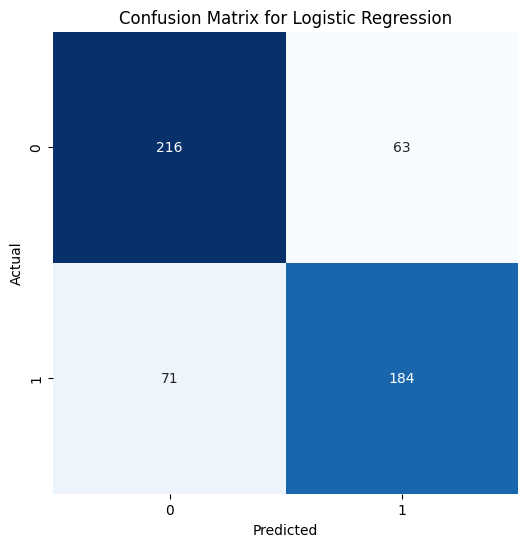

In [27]:
# Plot confusion matrix
cm = confusion_matrix(y_test, lr_predictions)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

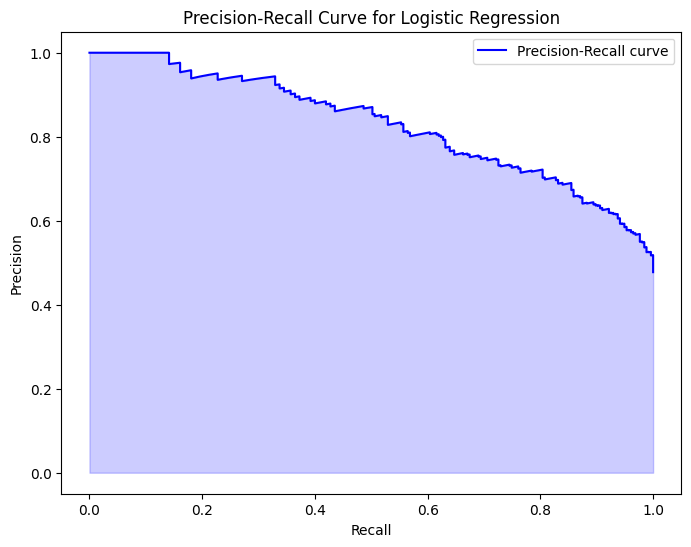

In [28]:
from sklearn.metrics import precision_recall_curve

# Get precision and recall values
precision, recall, _ = precision_recall_curve(y_test, grid_lr.best_estimator_.predict_proba(X_test)[:, 1])

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', label='Precision-Recall curve')
plt.fill_between(recall, precision, alpha=0.2, color='blue')
plt.title('Precision-Recall Curve for Logistic Regression')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

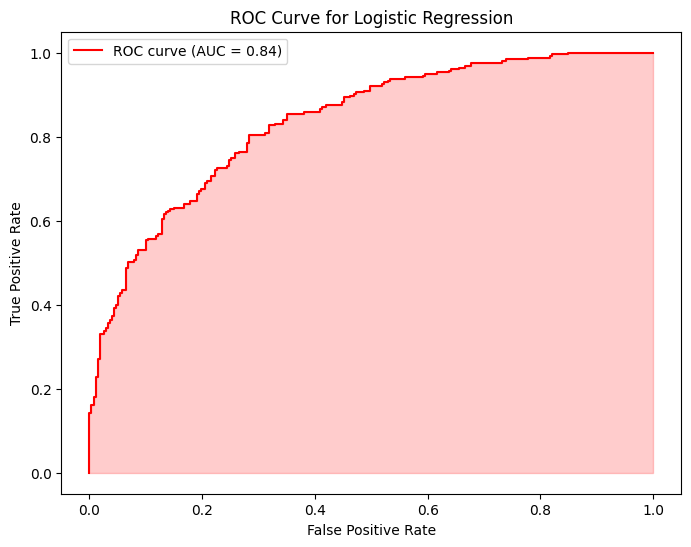

In [29]:
from sklearn.metrics import roc_curve, auc

# Get ROC curve values
fpr, tpr, thresholds = roc_curve(y_test, grid_lr.best_estimator_.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='r', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.fill_between(fpr, tpr, alpha=0.2, color='red')
plt.title('ROC Curve for Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

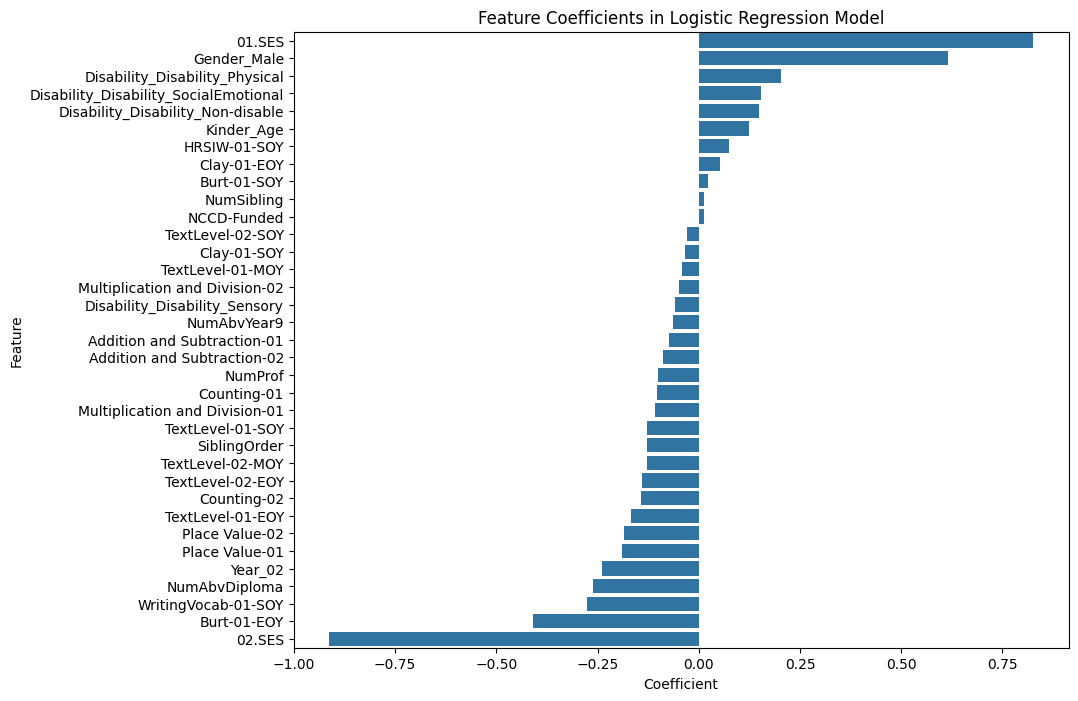

In [30]:
# Get feature names after encoding
encoded_feature_names = pd.get_dummies(data.drop(columns=['StudentID', 'Year3_Writing_At_Risk']), columns=['Gender', 'Disability'], drop_first=True).columns

# Get coefficients of the best model
coefficients = grid_lr.best_estimator_.coef_.flatten()

# Create a DataFrame to organize features and their coefficients
coef_df = pd.DataFrame({
    'Feature': encoded_feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)

# Plot feature importance (coefficients)
plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=coef_df)
plt.title('Feature Coefficients in Logistic Regression Model')
plt.show()

In [31]:
# Identify students predicted to be at risk ('At Risk' = 1)
at_risk_lr = X_test[lr_predictions == 1]

# Print the results
print("\nStudents Predicted to Be At Risk (Logistic Regression):\n", at_risk_lr)


Students Predicted to Be At Risk (Logistic Regression):
 [[-0.30341687  1.87959854  3.6113855  ... -0.21030218 -0.06997444
  -0.22905345]
 [-1.53931947 -1.13130116 -0.27690204 ... -0.21030218 -0.06997444
  -0.22905345]
 [-0.92136817 -0.55189813 -0.27690204 ... -0.21030218 -0.06997444
  -0.22905345]
 ...
 [-0.30341687 -1.24547276 -0.27690204 ... -0.21030218 -0.06997444
  -0.22905345]
 [-0.92136817  1.2774186  -0.27690204 ... -0.21030218 -0.06997444
  -0.22905345]
 [ 0.31453443  1.50770678 -0.27690204 ... -0.21030218 -0.06997444
  -0.22905345]]


In [ ]:
### 1. SES Backgrounds of Students (Year 1 and Year 2)
### - Based on the analysis of SES distribution, the students’ SES scores vary around [SES average]. Year 1 and Year 2 have [comparison to national averages].

### 2. Burt Reading Scores (Year 1 and Year 2)
### - The analysis shows that Burt Reading Scores generally [improve/remain the same/decline] from the start to the end of Year 1 and Year 2. There is [some/no] improvement.

### 3. Writing Skills in Year 1 and Risk (Logistic Regression)
### - Logistic Regression results indicate a strong relationship between WritingVocab-01-SOY and Year3_Writing_At_Risk, with low writing scores increasing the likelihood of being at risk.

### 4. Literacy and Numeracy Skills (Correlation)
### - Literacy and Numeracy are [strongly/moderately] correlated. Students with high literacy scores generally have high numeracy scores, and both affect Year3_Writing_At_Risk.

### 5. Disability and Writing At-Risk (Random Forest)
### - Disability conditions show a [significant/small] relationship with Year3_Writing_At_Risk. Students with disabilities are [more/less] likely to be at risk of underperforming in writing.

### 6. Insights for Early Interventions (K-Means)
### - K-Means clustering reveals distinct groups of students based on their writing and reading skills. These clusters suggest that [specific group] needs targeted interventions to improve their writing skills.